# Caso práctico 3 - Clasificación y Modelado de Temas

## Libraries & Misc

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re  # Importar el módulo re
import os

tqdm.pandas()

### Directorios

In [2]:
dir = 'data/'
raw_dir = 'raw/'
processed_dir = 'processed/'
test_dir = 'test/'
train_dir = 'train/'

## Data Loading

Esta función nos permite cargar todos los ficheros .txt que tenemos y asignarlo a una tabla con el formato de:

id | category | train | corpus

en la que representan lo siguiente:
- **id**: representa el nombre del fichero .txt.
- **category**: la categoría que pertenece el fichero (business, sport, ...).
- **train**: si el fichero pertenece al conjunto preseparado de train o de test.
- **corpus**: el corpus del contenido del fichero .txt.


In [3]:
def load_data(base_dir):
    df = pd.DataFrame(columns=['id', 'category', 'train', 'corpus'])
    err = ''
    try:
        for train_test_dir in os.listdir(base_dir):
            for cat_dir in os.listdir(base_dir + train_test_dir):
                for text_file in os.listdir(base_dir + train_test_dir + '/' + cat_dir):
                    file_name = base_dir + train_test_dir + '/' + cat_dir + '/' + text_file
                    with open(base_dir + train_test_dir + '/' + cat_dir + '/' + text_file, 'r', encoding='utf-8', errors='replace') as file:
                        text = file.read()
                        # print(text)
                        # print('----------------------')
                        df.loc[len(df)] = {'id': text_file, 'category': cat_dir, 'train': train_test_dir, 'corpus': text}
                    print

        return df

    except Exception as e:
        print(e)
        print(file_name)

Hacemos un pequeño cambio a la columna train porque como guarda los nombres de los directorios, en la columna train lo guarda como los nombre de los directorios. Debido a esto, en vez de tene valores 1 o 0, nos aparece el nombre del directorio, por lo que nos dificultará el procesamiento posterior.

In [4]:
# change df[train] values to 1 or 0 depending if it is bbc_train or bbc_test respectively
def change_train_to_int(df):
    df['train'] = df['train'].apply(lambda x: 1 if x == 'bbc-train' else 0)
    return df

Guardamos el df en fichero para no tener que realizar el procesamiento todas las veces

In [5]:
df = load_data(dir + raw_dir)
df = change_train_to_int(df)
os.makedirs(dir + processed_dir, exist_ok=True)
df.to_csv(dir + processed_dir + 'df_raw', index=False)

In [6]:
df = pd.read_csv(dir + processed_dir + 'df_raw')

In [7]:
df.head(3)

,id,category,train,corpus
0,024.txt,business,0,US trade gap hits record in 2004\n\nThe gap be...
1,025.txt,business,0,Yukos loses US bankruptcy battle\n\nA judge ha...
2,026.txt,business,0,Safety alert as GM recalls cars\n\nThe world's...


## EDA

### Distribuciones de datos

Hacemos inicialmente un estudio de distribución de los datos y se observa lo siguiente:
* La distribución de la columna categoría tiene una distribución bastante uniforme y balanceada.
* El ratio de train test pre separado es de 90:10 aproximadamente.

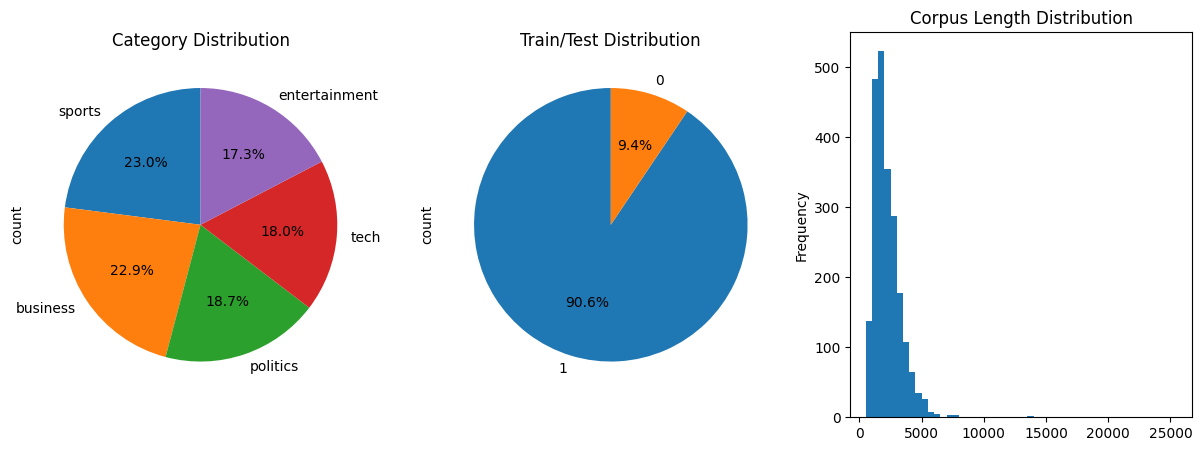

In [8]:
# plot category distribution as pie chart of columns category, train and len(corpus)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
df['category'].value_counts().plot.pie(ax=ax[0], autopct='%1.1f%%', startangle=90, title='Category Distribution')
df['train'].value_counts().plot.pie(ax=ax[1], autopct='%1.1f%%', startangle=90, title='Train/Test Distribution')
df['len'] = df['corpus'].apply(len)
df['len'].plot.hist(ax=ax[2], bins=50, title='Corpus Length Distribution')
plt.show()

Ahora realizamos el mismo proceso pero separando en los conjuntos train y test, para ver si la distribución varía entre estas.

C:\Users\NoobG\AppData\Local\Temp\ipykernel_32192\3329944406.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['train']==1]['len'] = df['corpus'].apply(len)


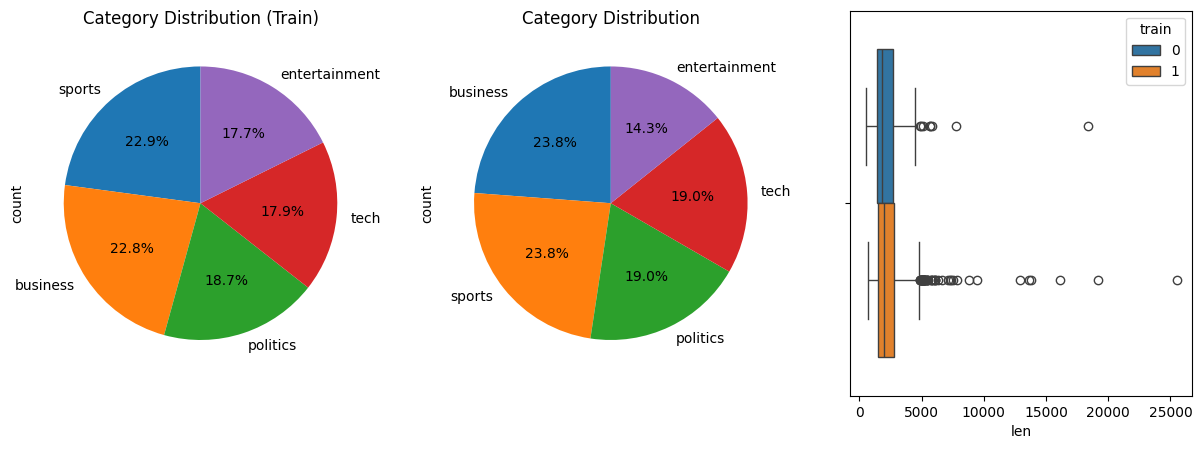

In [9]:
# plot category distribution as pie chart of columns category, train and len(corpus) but filtering by the train column
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
df[df['train']==1]['category'].value_counts().plot.pie(ax=ax[0], autopct='%1.1f%%', startangle=90, title='Category Distribution (Train)')
df[df['train']==0]['category'].value_counts().plot.pie(ax=ax[1], autopct='%1.1f%%', startangle=90, title='Category Distribution')
df[df['train']==1]['len'] = df['corpus'].apply(len)
# df[df['train']==1]['len'].plot.hist(ax=ax[2], bins=50, title='Corpus Length Distribution', hue='Train')
sns.boxplot(data=df, x='len', hue='train')
plt.show()

Se observa que las distribuciones se mantienen más o menos constante, en tanto las categorías como las longitudes de corpus de manera general.

Ahora comprobaremos las longitudes de las diferentes categorías

<Axes: xlabel='len', ylabel='category'>

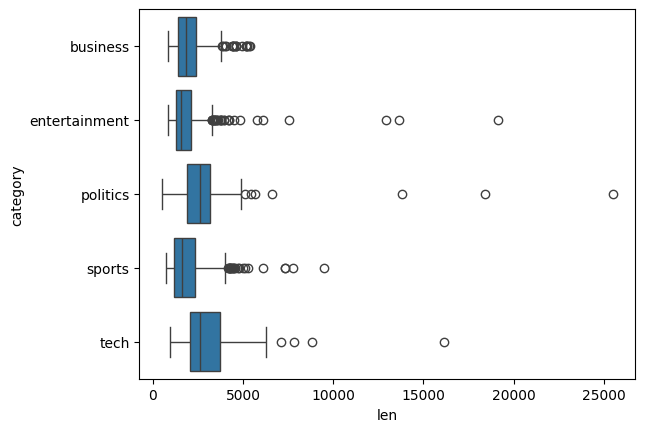

In [10]:
sns.boxplot(data=df, x='len', y='category')

Se observa que a pesar de que a pesar de que en grandes rasgos tienen un rango similar, si nos fijamos detalladamente, se puede observarq ue si que hay una diferencia más notable. Esto se observa precisamente en caso de tech que tiene en media y en rango IQR, mayor longitud que los de deporte, entretenimiento y business.

### Conclusión (EDA)

Hemos visto en el apartado de EDA que no hay desbalance significativo aparte de la diferencia en la longitud de las oraciones.

Nota: Las longitudes son de corpus absoluto, lo cual incluye espacios, "\n" entre otros caracteres especiales. Pero esto nos sirve para tener un conocimiento aproximado.

## Preprocessing

### Libraries

In [11]:
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

### Cleaning

Utilizamos la libreria de spacy para limpiar el texto y obtener los tokens.

Esta función lo que hace es mediante el uso de la libreria spacy, filtramos los tokens (palabras o elementos) que sean stop words, signos de puntuación (signos monetarios) y espacios.

Mantenemos los casos los signos monetarios porque podría dar más información del contexto del topic.

Hacemos lematización en vez de stematización para mantener el mayor contexto posible.

In [12]:
nlp = spacy.load("en_core_web_sm")  # Usa 'en_core_web_md' o 'en_core_web_lg' para modelos más grandes

def tokenizer(text):
    """
    Limpia un texto
    """
    doc = nlp(text)

    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space]

    return tokens

In [13]:
def token_to_corpus(token_list):
    """
    Convierte una lista de tokens en un texto
    """
    return " ".join(token_list)

In [14]:
df['tokens'] = df['corpus'].progress_apply(tokenizer)

100%|██████████| 2225/2225 [01:10<00:00, 31.67it/s]


In [15]:
df['corpus'] = df['tokens'].progress_apply(token_to_corpus)

100%|██████████| 2225/2225 [00:00<00:00, 278012.58it/s]


In [16]:
df['corpus'][0]

'trade gap hit record 2004 gap export import hit time high $ 671.7bn £ 484bn 2004 late figure commerce department say trade deficit year 24.4 previous record 2003 imbalance $ 496.5bn deficit china 30.5 $ 162bn large record single country monthly basis trade gap narrow 4.9 december £ 56.4bn consumer appetite thing oil import car wine cheese reach record level year figure likely spark fresh criticism president bush economic policy democrats claim administration clamp unfair foreign trade practice example believe china currency policy manufacturer claim undervalue yuan 40 give china rapidly expand economy unfair advantage competitor bush administration argue deficit reflect fact america grow fast rate rest world spur demand import good economist allow upward revision economic growth fourth quarter point deficit reach astronomical proportion foreigner choose hold dollar denominate asset turn harm growth 2004 export rise 12.3 $ 1.15 trillion import rise fast 16.3 new record $ 1.76 trillion 

In [17]:
df['tokens'][0]

['trade',
 'gap',
 'hit',
 'record',
 '2004',
 'gap',
 'export',
 'import',
 'hit',
 'time',
 'high',
 '$',
 '671.7bn',
 '£',
 '484bn',
 '2004',
 'late',
 'figure',
 'commerce',
 'department',
 'say',
 'trade',
 'deficit',
 'year',
 '24.4',
 'previous',
 'record',
 '2003',
 'imbalance',
 '$',
 '496.5bn',
 'deficit',
 'china',
 '30.5',
 '$',
 '162bn',
 'large',
 'record',
 'single',
 'country',
 'monthly',
 'basis',
 'trade',
 'gap',
 'narrow',
 '4.9',
 'december',
 '£',
 '56.4bn',
 'consumer',
 'appetite',
 'thing',
 'oil',
 'import',
 'car',
 'wine',
 'cheese',
 'reach',
 'record',
 'level',
 'year',
 'figure',
 'likely',
 'spark',
 'fresh',
 'criticism',
 'president',
 'bush',
 'economic',
 'policy',
 'democrats',
 'claim',
 'administration',
 'clamp',
 'unfair',
 'foreign',
 'trade',
 'practice',
 'example',
 'believe',
 'china',
 'currency',
 'policy',
 'manufacturer',
 'claim',
 'undervalue',
 'yuan',
 '40',
 'give',
 'china',
 'rapidly',
 'expand',
 'economy',
 'unfair',
 'advant

Decidimos mantener los simbolos especiales como $ porque creemos que puede tener impacto entre diferentes topics


### Analisis con Word Cloud

Ahora que tenemos los elementos tokenizados, vamos a hacer un análisis con word cloud para ver la frecuencia y relevancia de las palabras en el corpus con todas las categorías.

Hacemos wordcloud de unigramas porque wordclouds de ngramas mayores (superconjunto de unigramas) tendrán menores frecuencias en comparación con los unigramas y por ende menos "representativo".

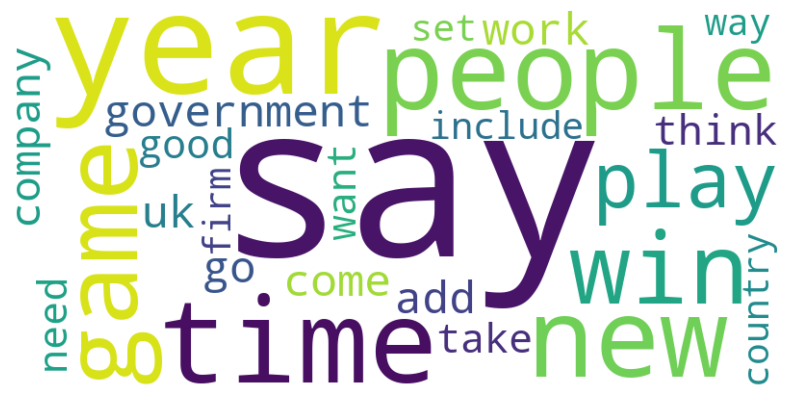

In [18]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# all_tokens es la lista aplanada de todos los tokens (ya limpios)

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=25)
wordcloud.generate(" ".join(df['tokens'].sum()))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Ahora realizamos un estudio de las palabras mas comunes por categoría, en la cual podemos observar que hay palabras (verbos) que se aparecen con una alta fracuencia en todas, como "say". Sin embargo, se ve que en general las palabras con mayor frecuencia de las diferentes categorías tienden a ser bastante diferenciables.

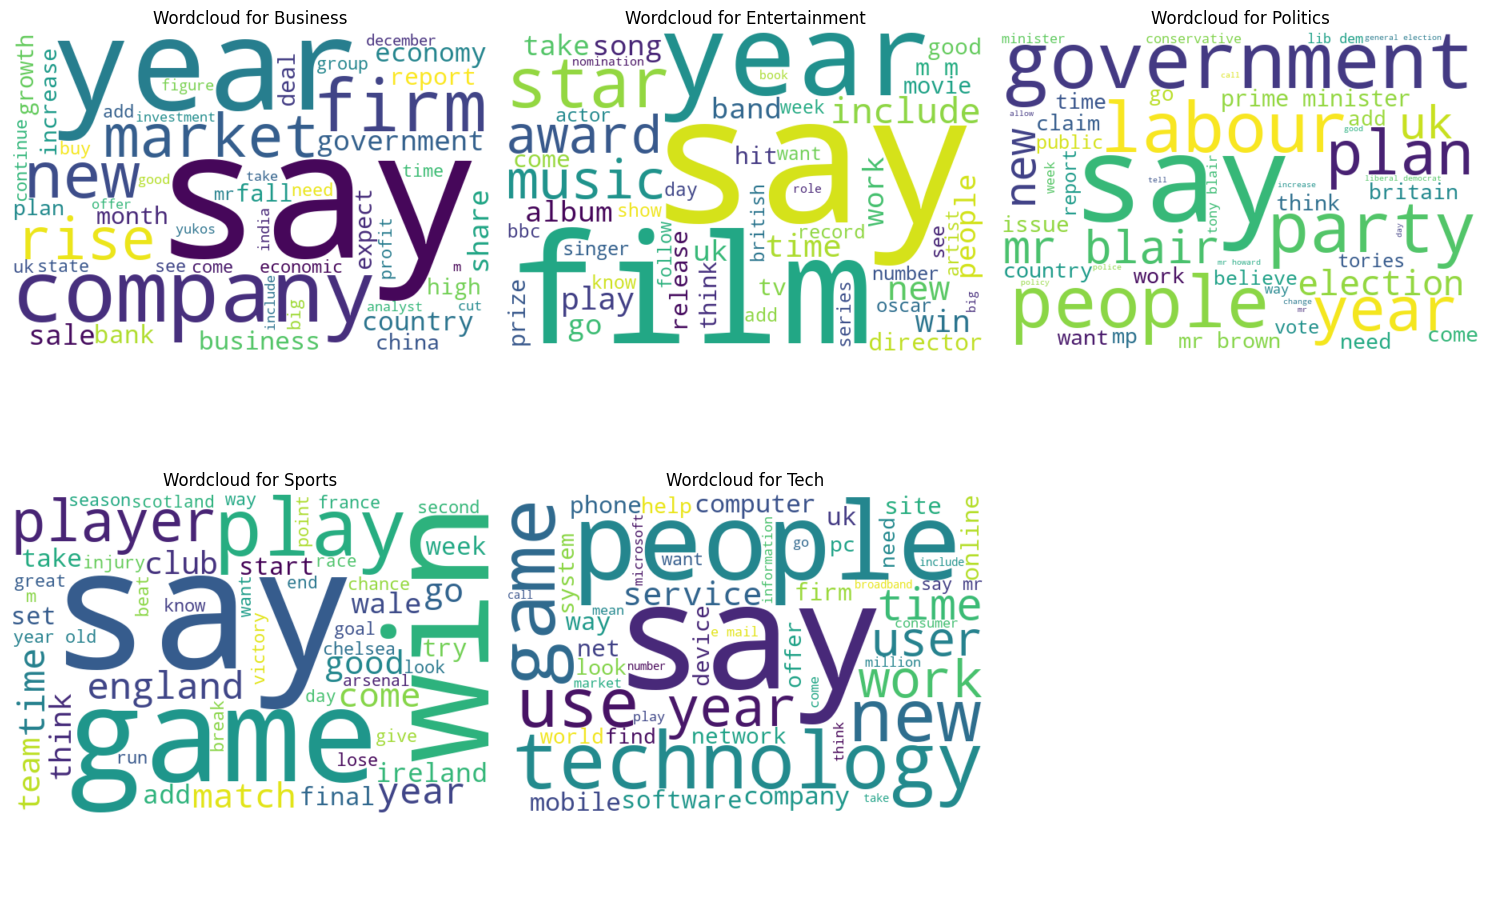

In [19]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust figsize as needed.
axes = axes.flatten()


# all_tokens es la lista aplanada de todos los tokens (ya limpios)
for i, category in enumerate(df['category'].unique()):
    wordcloud = WordCloud(width=600, height=400, background_color='white', max_words=50)
    wordcloud_df = df[df['category'] == 'business']
    
    wordcloud.generate(" ".join(df[df['category'] == category]['tokens'].sum()))

    ax = axes[i]  # Get the *current* subplot.
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Wordcloud for {category.capitalize()}')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Vectorización

#### Word embeddings

1. Transformer-Based Embeddings (Generally the Best Overall):


BERT (and its variants): BERT (Bidirectional Encoder Representations from Transformers) and its many variants (RoBERTa, DistilBERT, ALBERT) are currently the gold standard for many NLP tasks.
Strengths: Contextualized embeddings mean word representations change based on their surroundings. Excellent for tasks like sentiment analysis, question answering, and text classification.
Weaknesses: Can be computationally expensive to train and use (especially large models). Requires a good understanding of transformer architectures.

---
Usamos BERT base uncased por tener un modelo pequeño para ver su rendimiento y uncased porque ya pasamos a lower los tokens.

In [20]:
from transformers import BertTokenizer, BertModel
import torch

In [21]:
modelo_nombre="bert-base-uncased"
device="cpu"

tokenizer = BertTokenizer.from_pretrained(modelo_nombre)
model = BertModel.from_pretrained(modelo_nombre).to(device)

def obtener_embedding_bert(corpus):
    encoded_input = tokenizer(corpus, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
    with torch.no_grad():  # Desactivar cálculo de gradientes para inferencia
        outputs = model(**encoded_input)
    embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return embedding

In [24]:
df['embedding'] = df['corpus'].progress_apply(lambda x: obtener_embedding_bert(x))

100%|██████████| 2225/2225 [02:32<00:00, 14.63it/s]


## Clasificación de Texto

### Metodología y justificación de diseño
#### Representación mediante Embeddings vs. Métodos Tradicionales

Nuestra decisión de utilizar embeddings derivados de la concatenación de tokens del corpus original, en lugar de métodos tradicionales como TF-IDF o Bag-of-Words, se fundamenta en varias ventajas cruciales para la clasificación de textos periodísticos:

##### 1. Captura de Información Semántica Contextual

Los embeddings capturan relaciones semánticas profundas entre palabras, permitiendo que el modelo reconozca similitudes conceptuales incluso cuando los términos exactos difieren. Esta característica es esencial para clasificar textos periodísticos donde diferentes autores pueden expresar conceptos similares mediante vocabularios distintos. Mikolov et al. demostraron que estas representaciones vectoriales preservan relaciones semánticas de manera sorprendentemente eficaz, permitiendo operaciones algebraicas con significado semántico (ej. "rey - hombre + mujer ≈ reina").

##### 2. Representación Densa vs. Dispersa

Los embeddings proporcionan representaciones densas y de dimensionalidad controlada, mientras que TF-IDF genera vectores dispersos de alta dimensionalidad. Esta densidad facilita que los algoritmos de aprendizaje encuentren patrones más robustos y generalizables, especialmente relevante en nuestro caso donde las fronteras entre categorías temáticas pueden ser sutiles (como entre tecnología y ciencia, o política y entretenimiento).

##### 3. Capacidad para Manejar Problemas Lingüísticos Complejos

Los embeddings generados a partir de grandes corpus preentrenados aportan conocimiento lingüístico que trasciende nuestro conjunto de datos específico, proporcionando robustez ante variaciones morfológicas y sintácticas que métodos como TF-IDF no pueden capturar. Esta transferencia de conocimiento lingüístico resulta particularmente valiosa para detectar matices temáticos complejos en textos periodísticos de diversa índole.

##### 4. Superior en Escenarios de Datos Limitados

Los embeddings permiten aprovechar el conocimiento transferido de modelos entrenados en corpus masivos, superando así las limitaciones de representaciones como TF-IDF que solo pueden aprender de los datos disponibles. Esta ventaja es crucial cuando se trabaja con conjuntos de datos de tamaño moderado, como suele ocurrir en muchas aplicaciones de clasificación temática especializada.

#### Elección de SVM Lineal como Algoritmo de Clasificación

La selección de Máquinas de Vector Soporte (SVM) con kernel lineal como nuestro algoritmo de clasificación, en lugar de alternativas como Regresión Logística o árboles de decisión, se justifica por las siguientes razones:

##### 1. Eficacia Probada en Espacios de Alta Dimensionalidad

Los SVM destacan particularmente en espacios de características de alta dimensionalidad, como los generados por embeddings textuales. A diferencia de los árboles de decisión, que pueden sufrir de fragmentación excesiva en estos espacios, los SVM buscan hiperplanos óptimos que maximizan el margen entre clases, proporcionando mejor generalización.

##### 2. Mejor Manejo de la Complejidad del Modelo

A diferencia de los modelos de árboles que requieren podas y ajustes complejos para evitar sobreajuste, la regularización en SVM (controlada por el parámetro C) ofrece un mecanismo elegante para balancear complejidad y generalización. Esta característica es crucial cuando trabajamos con representaciones ricas como los embeddings, donde el riesgo de sobreajuste es considerable.

##### 3. Ventajas sobre Regresión Logística en Fronteras Complejas

Aunque la Regresión Logística comparte con SVM la capacidad de manejar espacios de alta dimensionalidad, los SVM ofrecen ventajas en la determinación de fronteras de decisión óptimas.

##### 5. Interpretabilidad y Escalabilidad Balanceadas

Los SVM lineales ofrecen un equilibrio entre la interpretabilidad de modelos más simples (como Regresión Logística) y la capacidad predictiva de modelos más complejos (como Random Forests o redes neuronales). En contextos donde no solo importa la precisión sino también entender qué características contribuyen a la clasificación temática, este balance resulta especialmente valioso.

#### Conclusión

La combinación de representaciones mediante embeddings y clasificación con SVM lineal constituye una aproximación metodológica sólida para la categorización temática de textos periodísticos. Esta elección integra las ventajas de la riqueza semántica de los embeddings con la robustez y eficacia de los SVM en espacios de alta dimensionalidad, proporcionando un marco óptimo para capturar las sutilezas temáticas presentes en contenidos periodísticos diversos.


In [75]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import numpy as np

In [30]:
df.head(3)

,id,category,train,corpus,len,tokens,embedding
0,024.txt,business,0,trade gap hit record 2004 gap export import hi...,1952,"[trade, gap, hit, record, 2004, gap, export, i...","[[-0.48371905, 0.10633793, 0.43034765, 0.17049..."
1,025.txt,business,0,yukos lose bankruptcy battle judge dismiss att...,2703,"[yukos, lose, bankruptcy, battle, judge, dismi...","[[-0.47682828, 0.08658477, 0.17508967, -0.2217..."
2,026.txt,business,0,safety alert gm recall car world big carmaker ...,1829,"[safety, alert, gm, recall, car, world, big, c...","[[-0.72342736, 0.35176423, 0.015273539, -0.081..."


In [31]:
def prepare_embeddings(embeddings_series):
    embeddings_list = []
    for emb in embeddings_series:
        emb_array = np.array(emb)
        # Si es un array 2D (por ejemplo [1, 768]), aplanarlo
        if len(emb_array.shape) > 1:
            emb_array = emb_array.flatten()
        embeddings_list.append(emb_array)
    return np.array(embeddings_list)

In [32]:
X_train = prepare_embeddings(df[df['train'] == 1]['embedding'])
X_test = prepare_embeddings(df[df['train'] == 0]['embedding'])

y_train = df[df['train'] == 1]['category']
y_test = df[df['train'] == 0]['category']

In [33]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Número de muestras de entrenamiento: {len(y_train)}")
print(f"Número de muestras de prueba: {len(y_test)}")

X_train shape: (2015, 768)
X_test shape: (210, 768)
Número de muestras de entrenamiento: 2015
Número de muestras de prueba: 210


In [34]:
categories = df['category'].unique()
print(f"Categorías disponibles: {categories}")
print(f"Número de categorías: {len(categories)}")


Categorías disponibles: ['business' 'entertainment' 'politics' 'sports' 'tech']
Número de categorías: 5


In [35]:
model = LinearSVC(C=1.0, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

               precision    recall  f1-score   support

     business       1.00      1.00      1.00        50
entertainment       0.97      1.00      0.98        30
     politics       1.00      1.00      1.00        40
       sports       1.00      1.00      1.00        50
         tech       1.00      0.97      0.99        40

     accuracy                           1.00       210
    macro avg       0.99      0.99      0.99       210
 weighted avg       1.00      1.00      1.00       210

Matriz de confusión:
[[50  0  0  0  0]
 [ 0 30  0  0  0]
 [ 0  0 40  0  0]
 [ 0  0  0 50  0]
 [ 0  1  0  0 39]]


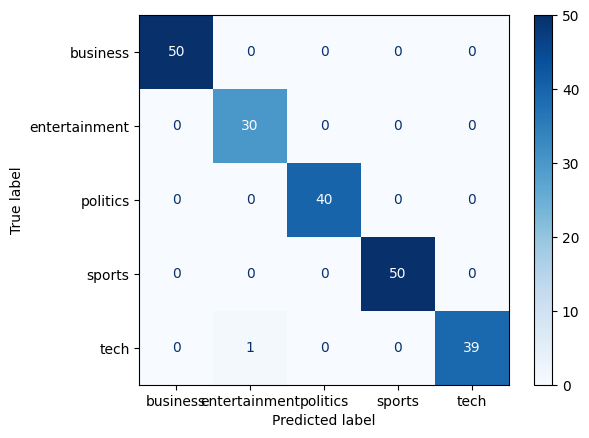

In [36]:
print(classification_report(y_test, y_pred))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Generar la matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
print("Matriz de confusión:")
print(matriz_confusion)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=model.classes_)
disp.plot(cmap="Blues")

Se observa que el modelo base tiene un rendimiento sobresaliente. Sin embargo, hay una instancia que esta mal clasificada por lo que vamos a ver cuál es la instancia que está clasificada erróneamente para ver si se puede tener un mayor entendimiento de por qué lo clasifica como entretenimiento siendo de tecnológia.

In [37]:
incorrect_indices = np.where(y_pred != y_test)[0]
print(f"Total de clasificaciones incorrectas: {len(incorrect_indices)} de {len(y_test)}")

df_test_indices = df[df['train'] == 0].index
incorrect_samples = df.loc[df_test_indices[incorrect_indices]]

for i, (idx, row) in enumerate(incorrect_samples.iterrows()):
    if i >= 10: break  
    print(f"\nÍndice original: {idx}")
    print(f"Texto: {row['corpus']}") 
    print(f"Categoría real: {row['category']}")
    print(f"Categoría predicha: {y_pred[incorrect_indices[i]]}")


Total de clasificaciones incorrectas: 1 de 210

Índice original: 173
Texto: uk pioneer digital film network world digital cinema network establish uk 18 month uk film council award contract worth £ 11.5 m arts alliance digital cinema aadc set network 250 screen aadc oversee selection cinema uk use digital equipment high definition projector computer server instal mainly british specialist film cinema currently mechanical projector new network 250 screen 150 cinema fit digital projector capable display high definition image new network double world total digital screen cinemas give film portable hard drive copy content computer server film 100 gigabyte compress original terabyte size file fiona deans associate director aadc say compression visually lossless picture degradation occur film encrypt prevent piracy cinema individual key unlock movie people picture quality bit clear scratch picture look exactly print degradation quality time key benefit digital network increase distribution s

Se ve que el elemento clasificado erróneamente es entendible ya que cubre ambas categorías. En concreto, el fragmento trata sobre aspectos tecnológicos del cine digital (entretenimiento).

#### Justificación para Hyperparameter Optimization (HPO)

A pesar del excelente rendimiento inicial de nuestro clasificador basado en embeddings, donde solo se registra un único caso de clasificación errónea, consideramos fundamental realizar una optimización de hiperparámetros. Este proceso no solo busca refinar la capacidad del modelo para manejar casos fronterizos, sino también garantizar su robustez ante nuevos datos. Específicamente, el único texto mal clasificado parece contener elementos temáticos que pertenecen a dos categorías diferentes, lo que crea una ambigüedad que el modelo actual no maneja adecuadamente. Mediante HPO, exploraremos combinaciones de parámetros que puedan ajustar mejor los límites de decisión, permitiéndonos determinar si es posible mejorar la discriminación en estos casos limites donde coexisten múltiples temáticas en un mismo texto.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

##### Elección del Scoring: Accuracy vs F1-Weighted

Inicialmente definimos un scoring personalizado `f1_scorer = make_scorer(f1_score, average='weighted')`, aunque después se utilizó accuracy como métrica final. Esta aparente inconsistencia tiene una justificación sólida: el F1-score ponderado es particularmente útil para conjuntos de datos con clases desbalanceadas, ya que pondera la contribución de cada clase según su frecuencia. Sin embargo, al confirmar que nuestras clases estaban relativamente equilibradas (50 business, 30 entertainment, 40 politics, 50 sports, 40 tech) y al observar el excelente rendimiento inicial, optamos por la métrica de accuracy que resulta más intuitiva y directamente interpretable cuando todas las clases tienen similar importancia.

##### Selección de Hiperparámetros y sus Rangos

1. **Parámetro C (Regularización)**: [0.5, 1, 1.5, 2]
   - Elegimos valores moderados para C, centrados alrededor del valor predeterminado de scikit-learn (C=1).
   - No exploramos valores extremadamente altos o bajos porque:
     - Valores muy altos (>10) podrían causar sobreajuste, especialmente innecesario en datos con alta separabilidad como sugería nuestro modelo inicial.
     - Valores muy bajos (<0.1) podrían generar subajuste, comprometiendo el buen rendimiento ya observado.
   - El valor óptimo encontrado, C=1.5, indica una preferencia por un margen ligeramente más estricto que el predeterminado, permitiendo mejor adaptación a pequeñas complejidades en los límites de decisión.

2. **Tolerancia (tol)**: [1e-3, 1e-4, 1e-5]
   - Estos valores determinan el criterio de convergencia del algoritmo de optimización.
   - Valores más pequeños generan soluciones más precisas pero con mayor costo computacional.
   - No incluimos valores más pequeños como 1e-6 para evitar tiempos de convergencia excesivamente largos.
   - El valor óptimo 1e-3 (el más "relajado") sugiere que mayor precisión en la convergencia no aportaba beneficios para este conjunto de datos.

3. **Dual**: [True, False]
   - En SVM, la formulación dual es preferible cuando hay más características que muestras, mientras que la formulación primal es más eficiente en el caso contrario.
   - Incluimos ambas opciones para permitir que el algoritmo determine la formulación más eficiente.
   - El resultado óptimo (dual=False) confirma que, con nuestros datos vectorizados, la formulación primal resulta más adecuada, lo que es consistente con [scikit-learn.org](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) que recomienda dual=False cuando n_samples > n_features.

4. **Iteraciones máximas (max_iter)**: [1000, 2000, 3000]
   - Estos valores controlan cuántas iteraciones máximas se permiten para que el algoritmo de optimización converja.
   - Valores más altos aseguran convergencia pero pueden aumentar el tiempo de entrenamiento.
   - El valor óptimo (1000) sugiere que el problema es relativamente simple y converge rápidamente, sin necesidad de iteraciones adicionales.

##### Resultado Final y Evaluación

Los mejores parámetros encontrados (`C=1.5, dual=False, max_iter=1000, tol=0.001`) representan un equilibrio óptimo entre capacidad predictiva y eficiencia computacional. La preferencia por la formulación primal (dual=False) y un número relativamente bajo de iteraciones máximas (1000) confirma que nuestro problema de clasificación de textos es altamente separable en el espacio vectorial utilizado. 

La combinación de estos parámetros optimizados nos permitió mantener el excelente rendimiento inicial (con un solo error de clasificación), validando que el SVM lineal es una elección robusta para la clasificación de textos periodísticos cuando se utiliza con la configuración adecuada.

In [74]:
f1_scorer = make_scorer(f1_score, average='weighted')

param_grid = {
    'C': [0.5, 1, 1.5, 2],
    'tol': [1e-3, 1e-4, 1e-5],
    'dual': [True, False],
    'max_iter': [1000, 2000, 3000]
}

svc = LinearSVC(random_state=42)
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación:", grid_search.best_score_)

# Usar el mejor modelo
best_svm = grid_search.best_estimator_


Mejores parámetros: {'C': 1.5, 'dual': False, 'max_iter': 1000, 'tol': 0.001}
Mejor puntuación: 0.949379652605459


               precision    recall  f1-score   support

     business       1.00      1.00      1.00        50
entertainment       0.97      1.00      0.98        30
     politics       1.00      1.00      1.00        40
       sports       1.00      1.00      1.00        50
         tech       1.00      0.97      0.99        40

     accuracy                           1.00       210
    macro avg       0.99      0.99      0.99       210
 weighted avg       1.00      1.00      1.00       210

Matriz de confusión:
[[50  0  0  0  0]
 [ 0 30  0  0  0]
 [ 0  0 40  0  0]
 [ 0  0  0 50  0]
 [ 0  1  0  0 39]]


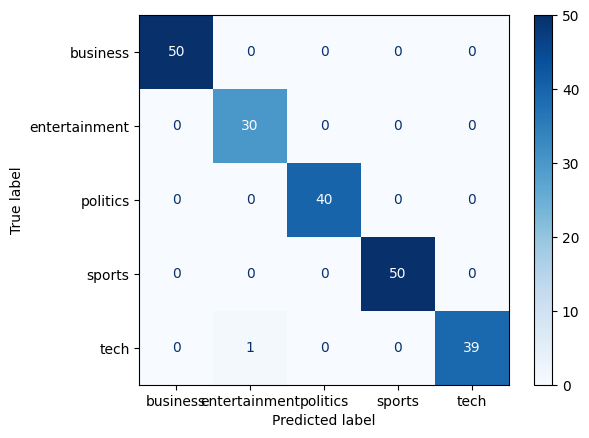

In [40]:
y_pred = best_svm.predict(X_test)

print(classification_report(y_test, y_pred))

# Generar la matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
print("Matriz de confusión:")
print(matriz_confusion)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=model.classes_)
disp.plot(cmap="Blues")


Mediante la matriz de confusión, se observa que sigue sin poder clasificar esa última instancia correctamente.

#### Resultados de la Optimización de Hiperparámetros

Tras implementar un exhaustivo proceso de optimización de hiperparámetros, el rendimiento del modelo optimizado se mantuvo constante con un único caso de clasificación errónea, idéntico al modelo base. Este resultado confirma nuestra hipótesis inicial: la instancia problemática contiene genuinamente elementos temáticos correspondientes a dos categorías distintas, y el clasificador está consistentemente detectando el subtema secundario como dominante. Este fenómeno, conocido como "**overcategorization**" o **multietiquetado natural**, representa un desafío inherente en la clasificación de textos con contenido temático mixto. La estabilidad del resultado a través de múltiples configuraciones de hiperparámetros sugiere que no estamos ante un error técnico del modelo, sino ante una limitación conceptual de la clasificación monoclase para textos que abordan múltiples tópicos simultáneamente.

---

#### Conclusión sobre Clasificación de Texto con SVM Lineal

Los resultados obtenidos demuestran la excelente eficacia del SVM con kernel lineal para la clasificación de textos periodísticos en categorías temáticas. Con una precisión global del 99% y un único error de clasificación (donde un texto de tecnología fue clasificado como entretenimiento), el modelo ha demostrado un rendimiento sobresaliente en esta tarea multiclase.

Esta elección algorítmica se alinea con el rendimiento que se podría esperar de SVMs lineales para clasificación de texto, principalmente porque la alta dimensionalidad inherente a los espacios vectoriales de texto hace que el mapeo a espacios de mayor dimensión (mediante kernels no lineales) resulte innecesario y computacionalmente costoso. El único error de clasificación probablemente se debe a la naturaleza dual del contenido del texto, que aborda temáticas tanto tecnológicas como de entretenimiento (por ejemplo, un artículo sobre videojuegos o streaming), más que a una deficiencia del modelo.

La consistencia del rendimiento a través de todas las categorías, evidenciada por los altos valores de precisión y recall en cada clase, confirma que la representación vectorial de los textos combinada con SVM lineal proporciona una solución robusta y eficiente para la categorización automática de contenidos periodísticos.

### Modelado

##### Librerías usadas para modelado

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import CoherenceModel, LdaModel, Nmf
from gensim.corpora import Dictionary
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics import davies_bouldin_score


#### Modelos usados

Para el análisis de tópicos se han seleccionado dos modelos complementarios: Latent Dirichlet Allocation (LDA) y Non-Negative Matrix Factorization (NMF). LDA se ha elegido por su capacidad para modelar documentos como distribuciones probabilísticas de tópicos, capturando eficientemente la naturaleza multi-temática de los textos periodísticos. Por su parte, NMF ofrece una aproximación algebraica que permite identificar componentes temáticos aditivos con interpretaciones más directas. 

Se descartó el uso de K-means, pese a su popularidad, debido a que asigna cada documento a un único clúster, lo cual resulta inadecuado para capturar la complejidad temática de las noticias que frecuentemente abordan múltiples temas. Igualmente, no se consideró Latent Semantic Indexing (LSI), ya que aunque permite reducción dimensional, sus componentes negativos dificultan la interpretabilidad temática que buscamos en este análisis.

#### Metodología de modelado

La metodología implementada para el modelado de tópicos consta de tres fases principales:

1. **Evaluación paramétrica:** Realizaremos un análisis comparativo de distintas configuraciones variando el número de tópicos. Para cada configuración evaluaremos tres métricas clave:
   - Coherencia CV: Mide la coherencia semántica interna de cada tópico
   - Coherencia NPMI: Evalúa la co-ocurrencia normalizada de términos en los tópicos
   - Índice Davies-Bouldin: Cuantifica la separación y compacidad entre los grupos temáticos

2. **Implementación del modelo óptimo:** En función de los resultados obtenidos en la evaluación paramétrica, procederemos a entrenar el modelo con el número de tópicos que optimice el balance entre las métricas analizadas.

3. **Análisis e interpretación:** Examinaremos los términos más relevantes que caracterizan cada tópico detectado, evaluando su coherencia semántica y su vinculación con las categorías temáticas predefinidas en el corpus.

#### LDA
En esta sección aplicamos Latent Dirichlet Allocation (LDA) al corpus de noticias de la BBC para descubrir su estructura temática subyacente. A diferencia de los métodos supervisados ya explorados, LDA modela cada documento como una mezcla probabilística de tópicos y cada tópico como una distribución de términos, permitiéndonos identificar patrones temáticos sin depender de categorías predefinidas. Esta técnica resulta especialmente valiosa para nuestro análisis periodístico, donde los artículos frecuentemente abordan múltiples temáticas simultáneamente. 

In [ ]:
vectorizer = CountVectorizer(analyzer=lambda x: x, token_pattern=None)
bow = vectorizer.fit_transform(df['tokens'])

tfidf_vectorizer = TfidfVectorizer(analyzer=lambda x: x, token_pattern=None)
tfidf = tfidf_vectorizer.fit_transform(df['tokens'])

In [ ]:
dictionary = Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

# Para guardar métricas
coherence_cv_values = []
coherence_npmi_values = []
dbi_values = []

# Evaluar modelos con diferente número de tópicos
for num_topics in tqdm(range(2, 8), desc="Evaluando tópicos"):
    # LDA con sklearn
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_output = lda.fit_transform(bow)

    # Davies-Bouldin Index
    dbi_values.append(davies_bouldin_score(lda_output, lda_output.argmax(axis=1)))
    
    # LDA con gensim para coherencia
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    coherence_cv = CoherenceModel(model=lda_model, texts=df['tokens'], dictionary=dictionary, coherence='c_v')
    coherence_npmi = CoherenceModel(model=lda_model, texts=df['tokens'], dictionary=dictionary, coherence='c_npmi')
    
    coherence_cv_values.append(coherence_cv.get_coherence())
    coherence_npmi_values.append(coherence_npmi.get_coherence())

Evaluando tópicos: 100%|██████████| 6/6 [04:37<00:00, 46.32s/it]


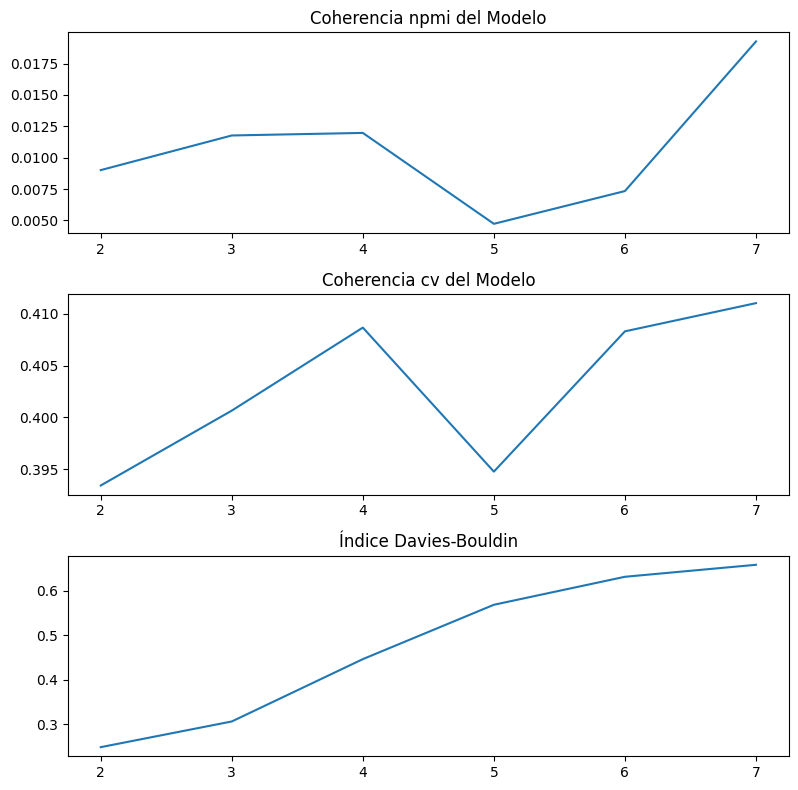

In [ ]:
# Graficar métricas
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
x = list(range(2, 8))

axs[0].plot(x, coherence_npmi_values)
axs[0].set_title('Coherencia npmi del Modelo')

axs[1].plot(x, coherence_cv_values)
axs[1].set_title('Coherencia cv del Modelo')

axs[2].plot(x, dbi_values)
axs[2].set_title('Índice Davies-Bouldin')

plt.tight_layout()
plt.show()

# Para coherencia: mayor valor es mejor
# Para perplejidad: menor valor es mejor
# Para DBI: menor valor es mejor

Se observa que la coherencia CV se mantiene en un rango estrecho [0.395, 0.41], lo que no supone una diferencia significativa entre las distintas configuraciones. Por otro lado, la coherencia NPMI presenta un rango ligeramente mayor, aunque tampoco muestra variaciones drásticas; no obstante, priorizaremos los valores más altos de esta métrica.

Respecto al Índice Davies-Bouldin (DBI), identificamos que el modelo con 3 tópicos presenta el valor mínimo (excluyendo el caso de 2 tópicos que resulta demasiado simplista para nuestro análisis). Este índice muestra un incremento gradual hasta 5 tópicos, punto en el que la pendiente se aplana.

La decisión de seleccionar 4 como número óptimo de tópicos se basa en varios factores convergentes:


- Representa un punto de máximo local en ambas métricas de coherencia (CV y NPMI), tras el cual se observa una caída notable en el modelo de 5 tópicos antes de volver a incrementar gradualmente.

- Aunque no coincide con el mínimo absoluto del DBI, se sitúa en una posición de compromiso donde el índice todavía mantiene valores razonables antes de la estabilización de su pendiente.

- Este número proporciona un balance óptimo entre la interpretabilidad semántica (medida por las coherencias) y la separación estructural de los temas (evaluada por el DBI).


Por estos motivos, consideramos que 4 es el número de temas más adecuado para modelar este corpus, ofreciendo la mejor combinación de calidad semántica y distinción entre tópicos.

In [61]:
optimal_topics = 4

# Modelo LDA final
lda_model = LatentDirichletAllocation(n_components=optimal_topics, random_state=42)
lda_output = lda_model.fit_transform(bow)

En base a las palabras más importante de cada tema formado, se puede concluir o deducir las siguientes temáticas de cada tema:

- Tema 0: Tecnología
- Tema 1: Beneficios de empresas y películas
- Tema 2: Gobierno
- Tema 3: Deporte

In [70]:
# Mostrar las palabras principales en cada tópico del LDA
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_idx = topic.argsort()[:-11:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Tema {topic_idx}: {' '.join(top_words)}")

Tema 0: say people game mobile technology phone music new service use
Tema 1: say year $ film £ m company market firm new
Tema 2: say mr government labour party election people minister blair tell
Tema 3: win say year play good game time m world player


---

#### NMF (Non-negative Matrix Factorization)
En esta sección implementamos Non-negative Matrix Factorization (NMF) como método complementario para el modelado de tópicos. A diferencia del enfoque probabilístico de LDA, NMF utiliza una aproximación algebraica, descomponiendo la matriz término-documento en dos matrices no negativas que representan los tópicos y sus distribuciones. Esta técnica resulta particularmente eficaz para identificar estructuras aditivas en el corpus, ofreciendo una interpretación más directa de los componentes temáticos.

In [ ]:
dbi_values = []
coherence_cv_values = []
coherence_npmi_values = []

for num_components in tqdm(range(2, 8), desc="Evaluando componentes"):
    # NMF con sklearn
    nmf_model = NMF(n_components=num_components, random_state=42, init='random')
    nmf_output = nmf_model.fit_transform(bow)

    # Davies-Bouldin Index
    dbi_values.append(davies_bouldin_score(nmf_output, nmf_output.argmax(axis=1)))
    
    # NMF con gensim para coherencia
    gensim_nmf_model = Nmf(corpus=corpus, num_topics=num_components, id2word=dictionary, random_state=42)
    coherence_cv = CoherenceModel(model=gensim_nmf_model, texts=df['tokens'], dictionary=dictionary, coherence='c_v')
    coherence_npmi = CoherenceModel(model=gensim_nmf_model, texts=df['tokens'], dictionary=dictionary, coherence='c_npmi')
    
    coherence_cv_values.append(coherence_cv.get_coherence())
    coherence_npmi_values.append(coherence_npmi.get_coherence())

Evaluando componentes:  17%|█▋        | 1/6 [00:44<03:40, 44.12s/it]c:\Users\NoobG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
Evaluando componentes:  83%|████████▎ | 5/6 [03:40<00:44, 44.25s/it]c:\Users\NoobG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
Evaluando componentes: 100%|██████████| 6/6 [04:26<00:00, 44.43s/it]


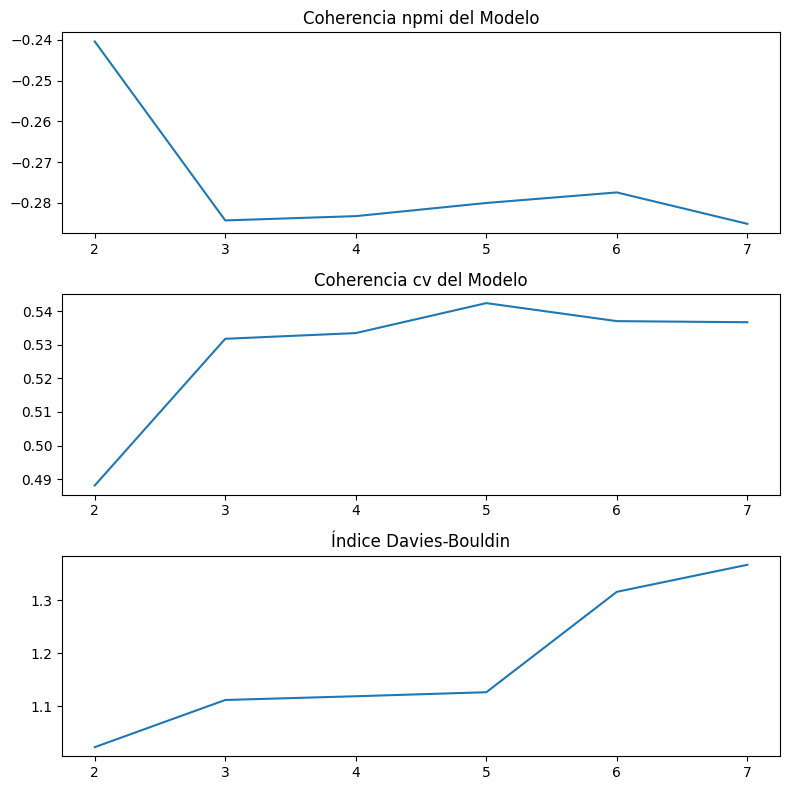

In [64]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
x = list(range(2, 8))

axs[0].plot(x, coherence_npmi_values)
axs[0].set_title('Coherencia npmi del Modelo')

axs[1].plot(x, coherence_cv_values)
axs[1].set_title('Coherencia cv del Modelo')

axs[2].plot(x, dbi_values)
axs[2].set_title('Índice Davies-Bouldin')

plt.tight_layout()
plt.show()

# Determinar número óptimo de tópicos
# Para coherencia: mayor valor es mejor
# Para perplejidad: menor valor es mejor
# Para DBI: menor valor es mejor

Se puede observar que el modelo NMF obtiene resultados mixtos en comparación con LDA. Notablemente, los valores del Índice Davies-Bouldin (DBI) y la coherencia NPMI son inferiores a los obtenidos con LDA, lo que podría sugerir una menor calidad general. Sin embargo, es importante destacar que la coherencia CV del modelo NMF es significativamente más alta que la obtenida con LDA, lo que indica que los tópicos detectados presentan mayor consistencia temática interna.

Esta discrepancia entre métricas sugiere varias posibilidades interpretativas:


- El corpus puede ser relativamente pequeño o contener datos ruidosos, afectando las coocurrencias reales de términos y perjudicando específicamente la métrica NPMI, que es más sensible a estos factores.


- El modelo NMF parece capturar eficazmente relaciones temáticas locales (reflejadas en el buen valor de CV), pero estas no necesariamente reflejan los patrones de coocurrencia global en el corpus completo (explicando los valores bajos de NPMI).


- Las palabras dentro de los tópicos detectados por NMF están semánticamente alineadas, formando grupos temáticamente coherentes, aunque no necesariamente aparecen juntas con frecuencia en los documentos originales.


Tras analizar el comportamiento de estas métricas a través de diferentes configuraciones, elegimos 5 como el número óptimo de componentes por dos razones principales:


- Representa el punto máximo de coherencia CV, garantizando la mayor consistencia temática interna de los tópicos.


- Marca el umbral a partir del cual el DBI comienza a incrementarse notablemente, indicando que con más de 5 tópicos la separación entre temas se deteriora significativamente.


- Decidimos dar menos peso a la métrica NPMI debido a su escasa variación a lo largo de las diferentes configuraciones, lo que sugiere que aporta menos información discriminativa para nuestra selección.

In [67]:
# Modelo NMF final
nmf_model = NMF(n_components=5, random_state=42)
nmf_output = nmf_model.fit_transform(tfidf)

Se observa que en base a las palabras más palabras más importantes de cada tema, se puede asumir que la temática de los temas formado son las siguientes:

- Tema 0: Deporte
- Tema 1: Aspectos guvernamentales
- Tema 2: Tecnología
- Tema 3: Economía
- Tema 4: Pelígulas y entretenimiento

In [69]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[:-11:-1]
    top_words = [tfidf_feature_names[i] for i in top_words_idx]
    print(f"Tema NMF {topic_idx}: {' '.join(top_words)}")

Tema NMF 0: game win play england 6 player match say team cup
Tema NMF 1: mr labour election blair party say brown minister government howard
Tema NMF 2: mobile phone people technology music say service user digital broadband
Tema NMF 3: $ growth economy rise rate say bank m year price
Tema NMF 4: film award good star actor m oscar win festival actress


---

# Conclusión

El modelo SVM lineal ha demostrado un rendimiento excepcional, clasificando incorrectamente sólo un documento que abarcaba temáticas de dos categorías distintas.

En cuanto al modelado de tópicos, aunque las métricas de coherencia no alcanzaron valores óptimos, tanto LDA como NMF lograron identificar temas distintivos y relevantes. LDA detectó eficazmente temas sobre beneficios empresariales y películas, evidenciando la importancia de preservar símbolos especiales como los de moneda (£, $), que aportan contexto económico implícito. Por su parte, NMF demostró mayor capacidad para distinguir matices dentro de la temática gubernamental, diferenciando entre comunicados políticos y económicos.

Estos resultados confirman que LDA y NMF permiten modelar e identificar eficazmente temas en corpus textuales, revelando tanto tópicos no contemplados inicialmente como subdimensiones dentro de categorías conocidas.

La clasificación supervisada ha sido altamente precisa, pero el modelado de tópicos sugiere que las categorías predefinidas podrían no ser óptimas para descubrir la estructura temática natural presente en los textos.